# AutoSleep Data 


In [23]:
import pandas as pd
import numpy as np 


# First we need to import our data from a csv file: 
df = pd.read_csv("AutoSleep.csv", header=0)
days_df = pd.read_csv("days_of_week.csv", header=0)

test_df = pd.read_csv("AutoSleep_test.csv", header=0)
days_test_df = pd.read_csv("days_test.csv", header=0)

## Explore the Data & Handle Missing Values
* With this dataset, it appears that the nights I wasn't wearing my watch were not recorded so there are no missing values
* There are, however, `np.NaN` values in the columns tracking blood oxygen levels because my Apple Watch doesn't have that capability. 
    * Since this data is missing throughout the entire time interval of the dataset, I will be deleting those rows from the dataframe.
* This is nice except when I want to compare it so another source of data, it will be a little more difficult to combine 
without filling in the missing dates on the autosleep data or removing those dates from the other dataset. 


In [24]:
# What are the column names?
# print(df.columns)
# It might be useful if I make a table that translates some of the column nates such as "ISO8601" and "qualityAvg7"

# print(df.head(5))
# print(df.tail(5))

# this for loop returns true if a column has any null values
for col in df:
    check_for_nan = df[col].isnull().values.any()
    if check_for_nan == True:
        # print (col, check_for_nan, df[col].isnull().count())
        df.drop(col, axis=1, inplace=True)
        test_df.drop(col, axis=1, inplace=True)

df.drop(['ISO8601', 'toDate', 'inBed',
       'awake', 'fellAsleepIn', 'sessions', 'asleepAvg7', 'efficiencyAvg7', 
       'qualityAvg7', 'sleepBPMAvg7', 'wakingBPMAvg7','hrvAvg7'], axis=1, inplace=True)

test_df.drop(['ISO8601', 'toDate', 'inBed',
       'awake', 'fellAsleepIn', 'sessions', 'asleepAvg7', 'efficiencyAvg7', 
       'qualityAvg7', 'sleepBPMAvg7', 'wakingBPMAvg7','hrvAvg7'], axis=1, inplace=True)


The following Columns have missing values for every instance in the dataset:
* deep 
* deepAvg7 
* dayBPM 
* dayBPMAvg7 
* SpO2Avg 
* SpO2Min 
* SpO2Max 
* respAvg 
* respMin 
* respMax 
* tags 
* notes 

## Now for some Summary Statistics: 
* Summarize the following into a pandas Series:
    * `nights_total` = total number nights logged
    * `avg_sleep` = average sleep 
    * `avg_[day]` = average sleep for each day of the week
    * `std_sleep` = standard deviation of sleep 
    * `std_[day]` = standard deviation for each day of the week
    * `mode_hours` = most common sleep length (rounded to the nearest hour)
    * `mode_day` = most common day of the week when mode sleep length occurred


In [25]:
# collecting summary statistics:
import utils 
import importlib
importlib.reload(utils)

summary_stats = []

merged_df = days_df.merge(df, on='fromDate')
merged_df.head()

merged_test = days_test_df.merge(test_df, on='fromDate')

# 1. total number of nights logged
nights_total = df.shape[0]
summary_stats.append(['nights total' ,nights_total])

# 2. average hours slept
# we need to convert the timestamps into numeric values before we can calculate the mean
merged_df = utils.clean_sleep(merged_df, "asleep")
test_df = utils.clean_sleep(test_df, 'asleep')
sleep_ser = merged_df["asleep"]   
avg_sleep_secs = sleep_ser.mean()
avg_sleep = utils.sec_to_hours(avg_sleep_secs)
median_sleep_secs = sleep_ser.median()
median_sleep = utils.sec_to_hours(median_sleep_secs)
# print("average time slept:", avg_sleep, "median:", median_sleep)
summary_stats.append(['average sleep', avg_sleep])
summary_stats.append(['median sleep', median_sleep])


grouped_by_day = merged_df.groupby('Day')
# SPLIT: 
monday_df = grouped_by_day.get_group("Monday")
tuesday_df = grouped_by_day.get_group("Tuesday")
wednesday_df = grouped_by_day.get_group("Wednesday")
thursday_df = grouped_by_day.get_group("Thursday")
friday_df = grouped_by_day.get_group("Friday")
saturday_df = grouped_by_day.get_group("Saturday")
sunday_df = grouped_by_day.get_group("Sunday")

# APPLY & COMBINE: 
# 3. average sleep for each day of the week
avg_sleep_per_day = pd.DataFrame([['monday', utils.sec_to_hours(monday_df['asleep'].mean())], 
                                  ['tuesday',utils.sec_to_hours(tuesday_df['asleep'].mean())],
                                  ['wednesday',utils.sec_to_hours(wednesday_df['asleep'].mean())],
                                  ['thursday',utils.sec_to_hours(thursday_df['asleep'].mean())],
                                  ['friday',utils.sec_to_hours(friday_df['asleep'].mean())],
                                  ['saturday',utils.sec_to_hours(saturday_df['asleep'].mean())],
                                  ['sunday',utils.sec_to_hours(sunday_df['asleep'].mean())]], 
                                  columns=['day', 'asleep'])
print(avg_sleep_per_day)


# 4. standard deviation of sleep
std_sleep = utils.sec_to_hours(sleep_ser.std())
summary_stats.append(['sleep std', std_sleep])
# print("STD:", std_sleep)


# 6. most common sleep length rounded to the nearest hour
ser = sleep_ser.copy()
for i in range(len(sleep_ser)):
    hours = round(sleep_ser[i]/3600, 0)
    ser[i] = hours
mode_hours = ser.mode()
# print("mode", mode_hours) # 8.78 is about 8 hours and 45 minutes! 
summary_stats.append(['sleep mode', mode_hours.iloc[0]])

summary_df = pd.DataFrame(summary_stats, columns=['metric', 'value'])
print(summary_df)

         day                                            asleep
0     monday                [7.0 hours 49.0 mins 30.0 seconds]
1    tuesday  [7.0 hours 18.0 mins 25.714285714286234 seconds]
2  wednesday                 [6.0 hours 9.0 mins 36.0 seconds]
3   thursday                [6.0 hours 42.0 mins 15.0 seconds]
4     friday                [8.0 hours 42.0 mins 36.0 seconds]
5   saturday                 [7.0 hours 9.0 mins 20.0 seconds]
6     sunday                 [8.0 hours 1.0 mins 15.0 seconds]
          metric                                            value
0   nights total                                               48
1  average sleep              [7.0 hours 23.0 mins 18.75 seconds]
2   median sleep                [7.0 hours 46.0 mins 0.0 seconds]
3      sleep std  [2.0 hours 7.0 mins 25.636114526029814 seconds]
4     sleep mode                                              9.0


### Plotting Some of the Data:

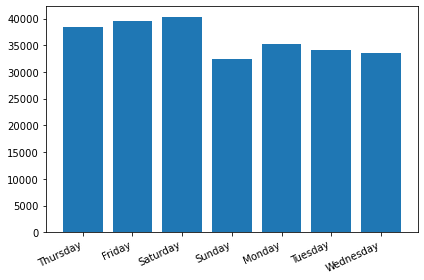

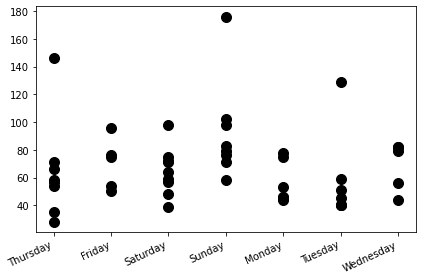

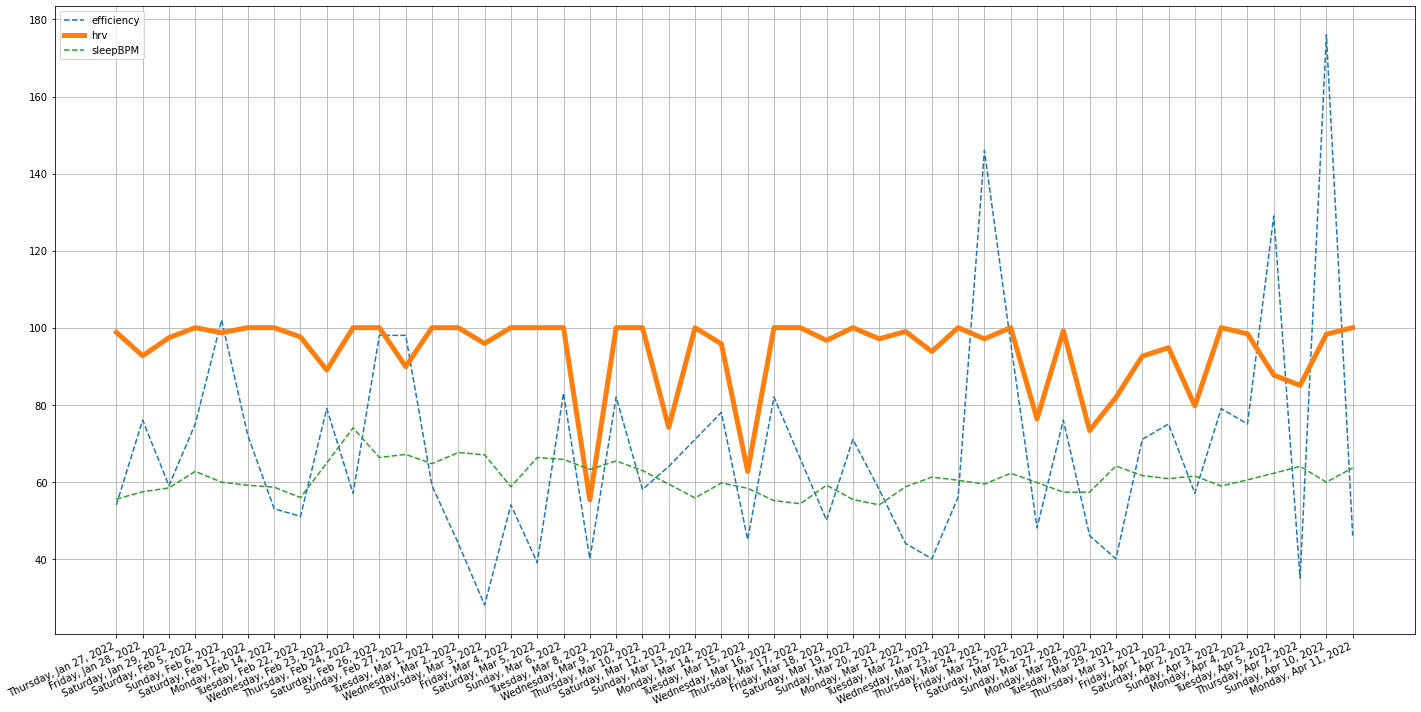

In [26]:
import matplotlib.pyplot as plt


utils.bar_graph_example(merged_df['Day'], merged_df['asleep'])

utils.scatter_chart_example(merged_df['Day'], merged_df['hrv'])

utils.line_chart_example(merged_df['fromDate'], merged_df['efficiency'], merged_df['hrv'], merged_df['sleepBPM'],
                        "efficiency", "hrv", "sleepBPM")




## KNN Classifier 

* Using the data that I have collected since pulling the original csv as the testing set

In [27]:
# Apply scaling 
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler

le = preprocessing.LabelEncoder()
df_encoded = merged_df.copy()
test_df_encoded = merged_test.copy()

clean_merged = df_encoded.drop(['fromDate', 'efficiency'], axis=1)
clean_test = test_df_encoded.drop(['fromDate', 'efficiency'], axis=1)
for col in clean_merged:
    # print(col)
    df_encoded[col] = le.fit_transform(clean_merged[col])
    # list(le.classes_,)
    test_df_encoded[col] = le.fit_transform(clean_test[col])

X_train = df_encoded.drop(['fromDate','efficiency'], axis=1)
y_train = df_encoded['efficiency']
y_train = y_train.astype('int')
# print(X_train, y_train, sep="\n")
# print(test_df_encoded)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train) 
# typically fit and transform are combined fit_transform()
# print("******\nX-train scaled:", X_train_scaled, "\n*******")
X_test = test_df_encoded.drop(['fromDate','efficiency'], axis=1)
X_test_scaled = scaler.transform(X_test)
# print(X_test_scaled)

# print(y_train)
# print(type(y_train))

In [28]:
from sklearn.neighbors import KNeighborsClassifier

print(len(X_test_scaled), len(y_train), len(X_train_scaled))
print(type(y_train))

# train/build/fit
knn_clf = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
knn_clf.fit(X_train_scaled, y_train)

# predict
y_predicted = knn_clf.predict(X_test_scaled)
print("the predicted values are:", y_predicted)

a = merged_test['efficiency'].to_list()
y_actual = [int(a) for a in a]
print(y_actual)

for i in range(len(y_predicted)):
    print(y_actual[i], y_predicted[i])

13 48 48
<class 'pandas.core.series.Series'>
the predicted values are: [ 62  97 100  62  62  62  96  62  97  96  62  62  62]
[100, 99, 100, 97, 100, 100, 99, 98, 97, 100, 95, 65, 100]
100 62
99 97
100 100
97 62
100 62
100 62
99 96
98 62
97 97
100 96
95 62
65 62
100 62


In [29]:
attribute = merged_df['efficiency']
attribute.describe()
# ax = attribute.plot.kde(ind=list(range(30,170)))

count     48.000000
mean      93.725000
std       10.357616
min       55.300000
25%       92.675000
50%       98.550000
75%      100.000000
max      100.000000
Name: efficiency, dtype: float64